# English/telugu Translator: Seq 2 Seq 

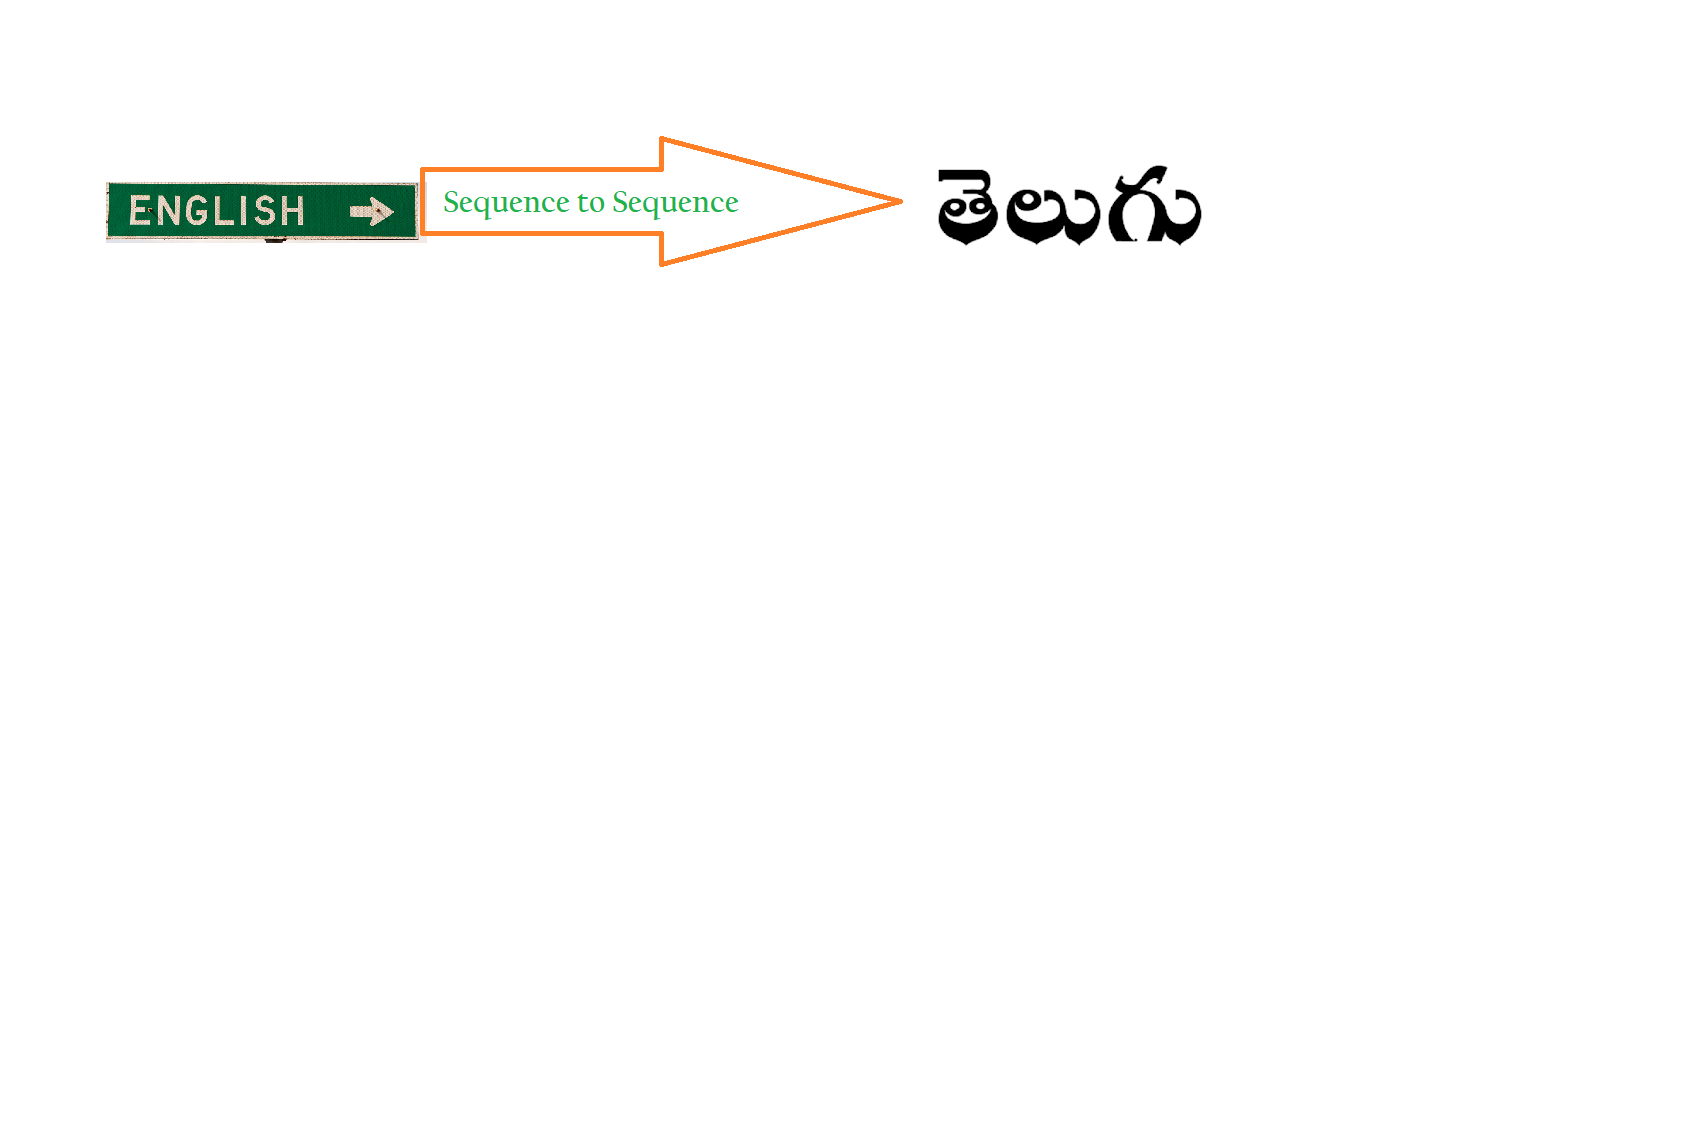

In [1]:
from IPython.display import Image
Image(filename='Untitled.png')

## Import Libraries

In [3]:
from collections import Counter
import operator
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
# Logging
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
# read phrases from english_telugu_data.txt file
english_sentances = []
telugu_sentances = []
with open("english_telugu_data.txt", mode='rt', encoding='utf-8') as fp:
    for line in fp.readlines():
        eng_tel = line.split("++++$++++")
        english_sentances.append(eng_tel[0])
        telugu_sentances.append(eng_tel[1])

In [5]:
df = pd.DataFrame({"english":english_sentances,"telugu":telugu_sentances})

In [6]:
df.head()

,english,telugu
0,His legs are long.,అతని కాళ్ళు పొడవుగా ఉన్నాయి.\n
1,Who taught Tom how to speak French?,టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు?\n
2,I swim in the sea every day.,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను.\n
3,Tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
4,Smoke filled the room.,పొగ గదిని నింపింది.\n


In [7]:
df.shape

(155798, 2)

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# clean english sentances
def clean_eng(text):
    # Lowercase all characters
    text = text.lower()
    # map contractions
    text = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split(" ")])
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    text= text.strip()

    return text

In [10]:
# clean telugu sentances
def clean_tel(text):
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove Telugu numbers from text
    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)
    # Remove extra spaces
    text= text.strip()
    
    return text

In [11]:
df["english"] = df["english"] .apply(lambda x: clean_eng(x))
df["telugu"] = df["telugu"] .apply(lambda x: clean_tel(x))

In [12]:
print("Total English records : ", df.english.shape[0])
print("Total telugu records : ", df.telugu.shape[0])

Total English records :  155798
Total telugu records :  155798


In [13]:
import string
def msg_clean(msg):
    clean =  [(char) for char in msg if char not in string.punctuation]
    clean = "".join(clean)
    return clean

In [14]:
df['english'].head()

0                                    his legs are long
1                   who taught tom how to speak french
2                          i swim in the sea every day
3    tom popped into the supermarket on his way hom...
4                                smoke filled the room
Name: english, dtype: object

In [15]:
df=df.sample(18000)

## DATA CLEANING

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['english'].tolist(), df['telugu'].tolist(), test_size=0.2, random_state=42)

In [17]:
print("\nsample senetnce in English Language : ",X_train[5])
print("telugu Language : ",y_train[5])


sample senetnce in English Language :  he knows how to behave in public
telugu Language :  బహిరంగంగా ఎలా ప్రవర్తించాలో ఆయనకు తెలుసు


In [18]:
def preprocess(seq):         
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' 
    for ele in seq: 
        if ele in punc: 
            seq = seq.replace(ele, "") 
    line = seq.split()
    line = [word.lower() for word in line]
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    line = [re_print.sub('', w) for w in line]
    return " ".join(line)

In [19]:
english_sentences = []          
telugu_sentences = []         
telugu_sentences_inputs = []

In [20]:
for i in range(len(X_train)):
    input_sentence = preprocess(X_train[i])
    output = y_train[i]
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    english_sentences.append(input_sentence)
    telugu_sentences.append(output_sentence)
    telugu_sentences_inputs.append(output_sentence_input)

In [21]:
print("Number of English samples :", len(english_sentences))
print("Number of output samples:", len(telugu_sentences))
print("Number of input output samples:", len(telugu_sentences_inputs))

Number of English samples : 14400
Number of output samples: 14400
Number of input output samples: 14400


In [22]:
# download nltk packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
total_input = english_sentences +  [preprocess(line) for line in X_test]
max_input_len = max([len(txt.split()) for txt in total_input])

In [24]:
print("Max length for input : : ",max_input_len)

Max length for input : :  26


In [25]:
print("Max length for output:",max([len(txt.split()) for txt in telugu_sentences]))

Max length for output: 17


In [26]:
unique_input_tokens = set()
for line in total_input:
    words = line.split()
    for word in words:
        unique_input_tokens.add(word)
print("Unique tokens for inputs : ",len(unique_input_tokens))

Unique tokens for inputs :  5843


In [27]:
unique_output_tokens = set()
for line in telugu_sentences:
    words = line.split()
    for word in words:
        unique_output_tokens.add(word)
print("Unique tokens for outputs : ",len(unique_output_tokens))

Unique tokens for outputs :  11426


In [28]:
# last 2 sentences of preprocessed text
print("\nLast 2 sentences of preprocessed text")
for inpu,outpu in zip(english_sentences[-2:],telugu_sentences[-2:]):
  print(inpu,"   -->   ",outpu)


Last 2 sentences of preprocessed text
tom did not want me to go to boston with him    -->    నేను అతనితో బోస్టన్‌కు వెళ్లాలని టామ్ కోరుకోలేదు <eos>
do not you see the clock    -->    మీకు గడియారం కనిపించలేదా <eos>


In [29]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(total_input)

In [30]:
input_integer_seq = input_tokenizer.texts_to_sequences(english_sentences)
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

Total unique words in the input: 5843


In [31]:
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Length of longest sentence in input: 26


In [32]:
output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(telugu_sentences + telugu_sentences_inputs)

In [33]:
output_integer_seq = output_tokenizer.texts_to_sequences(telugu_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(telugu_sentences_inputs)

In [34]:
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

Total unique words in the output: 11425


In [35]:
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Length of longest sentence in the output: 17


## Paadding 

In [36]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[0]:", encoder_input_sequences[0])

encoder_input_sequences.shape: (14400, 26)
encoder_input_sequences[0]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  40  19 291]


In [37]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post') 
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[0]:", decoder_input_sequences[0])
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

decoder_input_sequences.shape: (14400, 17)
decoder_input_sequences[0]: [   2   92 4782    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [38]:
decoder_targets_one_hot = np.zeros((len(english_sentences),max_out_len,num_words_output),dtype='float32')
print(decoder_targets_one_hot.shape)

(14400, 17, 11426)


In [39]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [40]:
# Encoder
LSTM_NODES =128
BATCH_SIZE = 16
EPOCHS = 10
LSTM_NODES =128

embedding_layer = Embedding(len(word2idx_inputs) + 1, 100, input_length=max_input_len)
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [41]:
# Decoder
decoder_inputs_placeholder = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [42]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 100)      584400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      1462528     input_2[0][0]                    
______________________________________________________________________________________________

In [43]:
history = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1,)

Epoch 1/10
810/810 [==============================] - 134s 161ms/step - loss: 2.0816 - accuracy: 0.7380 - val_loss: 1.8228 - val_accuracy: 0.7604
Epoch 2/10
810/810 [==============================] - 130s 160ms/step - loss: 1.7570 - accuracy: 0.7674 - val_loss: 1.7182 - val_accuracy: 0.7765
Epoch 3/10
810/810 [==============================] - 130s 160ms/step - loss: 1.6572 - accuracy: 0.7815 - val_loss: 1.6551 - val_accuracy: 0.7875
Epoch 4/10
810/810 [==============================] - 130s 160ms/step - loss: 1.5882 - accuracy: 0.7897 - val_loss: 1.6163 - val_accuracy: 0.7934
Epoch 5/10
810/810 [==============================] - 130s 160ms/step - loss: 1.5344 - accuracy: 0.7968 - val_loss: 1.5799 - val_accuracy: 0.7991
Epoch 6/10
810/810 [==============================] - 129s 160ms/step - loss: 1.4892 - accuracy: 0.8035 - val_loss: 1.5585 - val_accuracy: 0.8016
Epoch 7/10
810/810 [==============================] - 130s 160ms/step - loss: 1.4510 - accuracy: 0.8095 - val_loss: 1.5423 -

In [44]:
model.save('seq2seq_source_target.h5')

In [45]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label=' training data')
    plt.plot(history.history['val_accuracy'], 'ro--' ,label='validation data')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label=' training data')
    plt.plot(history.history['val_loss'],'ro--' , label='validation data')
    plt.title('Loss for Text Classification')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

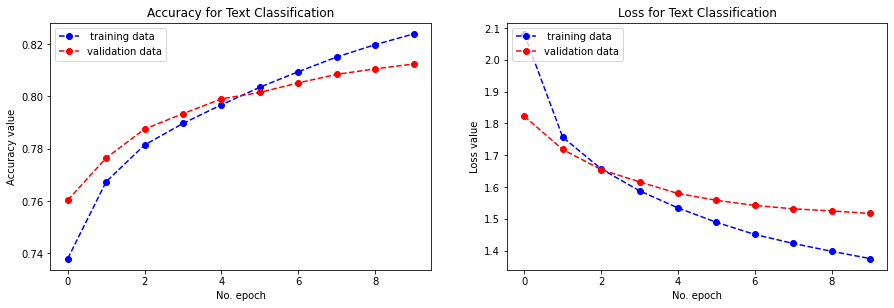

In [46]:
plot_accuracy_loss(history)

In [47]:
# Prediction
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [48]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [49]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [50]:
# Dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [51]:
# utility function for inference phase
def inference(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        if eos == idx:
            break
        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [52]:

# Testing on few random samples
for _ in range(10):
    i = np.random.choice(len(english_sentences))
    eng_sen = encoder_input_sequences[i:i+1]
    translation = inference(eng_sen)
    print('*********************************************')
    print('English: {}'.format(english_sentences[i]))
    print('Prediction: {}'.format(translation))
    print('Ground truth: {}'.format(telugu_sentences[i]))

*********************************************
English: where is boston
Prediction: బోస్టన్‌లో ఎక్కడ ఉంది
Ground truth: బోస్టన్ ఎక్కడ ఉంది <eos>
*********************************************
English: tom said he would help me
Prediction: టామ్ నాకు సహాయం చేయడానికి చెప్పాడు
Ground truth: టామ్ నాకు సహాయం చేస్తానని చెప్పాడు <eos>
*********************************************
English: i do not like this neighborhood much
Prediction: ఈ నాకు ఇది ఇష్టం లేదు
Ground truth: ఈ పరిసరం నాకు పెద్దగా ఇష్టం లేదు <eos>
*********************************************
English: tom was sad
Prediction: టామ్ ఉన్నాడు
Ground truth: టామ్ విచారంగా ఉన్నాడు <eos>
*********************************************
English: iceland has an area of about 103000 square kilometres
Prediction: దాని గురించి సంవత్సరం ఒక రోజు
Ground truth: ఐస్లాండ్ విస్తీర్ణం 103000 చదరపు కిలోమీటర్లు <eos>
*********************************************
English: i will make a phone call
Prediction: నేను ఒక కోసం మీకు ఒక రోజు
Ground truth: నేను ఫోన్ చే

In [53]:
# Automatic evaluation with the BLEU metric
def encode_to_input(s):
    s = preprocess(s)
    x  = []
    for w in s.split():
        x.append(word2idx_inputs[w.lower()])
    return pad_sequences([x], maxlen=max_input_len)

In [54]:
from nltk.translate.bleu_score import sentence_bleu

In [55]:
# Calculating average BLEU score on test set (2000 size in our case)
def evaluate_model(X,Y):
    count = 0
    total_score = 0
    for x,y in zip(X,Y):
        encoded_x = encode_to_input(x)
        translated_x =inference(encoded_x)
        reference = [y.split()]
        candidate = translated_x.split()
        blue_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
        count = count +1
        total_score = total_score + blue_score
        if count%100==0:
          print(count,blue_score,total_score,x,y)
    return total_score/count

In [56]:
average_score = evaluate_model(X_test,y_test)
print("Average BLEU score",average_score)

100 0.4 31.669726312831063 i met my friends yesterday నేను నిన్న నా స్నేహితులను కలిశాను
200 0.25 65.64121662915065 tom was able to find true happiness టామ్ నిజమైన ఆనందాన్ని పొందగలిగాడు
300 0 100.22251667136021 my father was about to leave when the telephone rang టెలిఫోన్ మోగినప్పుడు నాన్న బయలుదేరబోతున్నాడు
400 0.5841005873035536 126.8312101704458 we do not want to go to boston మేము బోస్టన్‌కు వెళ్లడం ఇష్టం లేదు
500 0.49123845184678916 160.7907963308859 tom and mary are both good teachers టామ్ మరియు మేరీ ఇద్దరూ మంచి ఉపాధ్యాయులు
600 0.5 191.4211075416435 i am not going to defend tom నేను టామ్‌ను రక్షించబోతున్నాను
700 0.2 224.59513396815998 this temple dates back to 780 ఈ ఆలయం 780 నాటిది
800 0.18393972058572117 253.57465105661825 tom ate all the cookies టామ్ అన్ని కుకీలను తిన్నాడు
900 0.375 285.1643585686087 neither tom nor mary wanted to do that టామ్ లేదా మేరీ ఇద్దరూ అలా చేయాలనుకోలేదు
1000 0.23884377019126307 314.6125848045376 this window is bulletproof ఈ విండో బుల్లెట్ ప్రూఫ్
1100 0.389